# Rigorous eigenvalue bounds for the Laplacian eigenvalue problem

On a square domain $\Omega$, consider the following eigenvalue problem

$$
-\Delta u = \lambda u \mbox{ in } \Omega, u=0 \mbox{ on } \partial \Omega \:.
$$

The variational formulation for the above eigenvalue problem is to find $u\in H_0^1(\Omega)$ and $\lambda \in R$ such that
$$
\int_{\Omega} \nabla u \cdot \nabla v dx = \lambda \int_{\Omega} uvdx \mbox{ for all }  v \in H_0^1(\Omega) \:.
$$

Below, we show how to solve the eigenvalue problem and obtain rigorous eigenvalue bounds step by step.

Particular, in this speical case, the first 9 eigenvalue are given by 
$$
\left\{\frac{\lambda_i}{\pi^2} \right\}_{i=1}^{9}  = \{2,5,5,8,10,10,13,13,18\} \:.
$$

### Objective:
    
Calculate the lower and upper bounds for the leading 9 exact eigenvalues.


<em>Last updated by Xuefeng LIU, July. 13, 2017</em>

## Step 1 : Mesh generation and FEM space definition

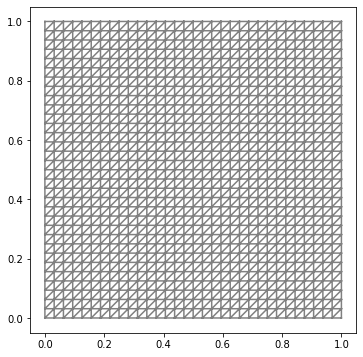

In [19]:
from dolfin import *
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

#Set domain to be "square" or "l-shape"
domain="square" 

# Square domain
if domain == "square":
    N=32; h=1.0/N
    mesh = UnitSquareMesh(N, N)

# L-shaped domain
if domain == "l-shape":
    N=4; h=1.0/N
    mesh = Mesh("L_uniform.xml")
    for k in range(0,N-1):
        mesh = refine(mesh)

plot(mesh)

V = FunctionSpace(mesh, "CR", 1)

# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)

## Step 2: Variational formulation

In [20]:
# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system

# Assemble the stiffness matrix and the mass matrix.
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)

# set the diagonal elements of B corresponding to boundary nodes to zero to
# remove spurious eigenvalues.
bc.zero(B)

## Step 3: Calculate matrix and solve the matrix eigenvalue problem

In [21]:
def scipy_get_leading_eigenvalues(MatA, MatB, nreq, msg=True):
    
    import numpy as np
    from scipy.sparse.linalg import eigsh
    import scipy.sparse as sp
    
    row_,col_,val_ = MatA.mat().getValuesCSR()
    sA = sp.csr_matrix((val_,col_,row_))
    row_,col_,val_ = MatB.mat().getValuesCSR()
    sB = sp.csr_matrix((val_,col_,row_))
    
    #Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html
    #Since the "LM" calculation is more stable,we first fetch the largest eigenvalues of Mx=lambda Ax and then take the reverse.
    reverse_eigenvalues, reverse_eigenvectors = eigsh(sB,k=nreq, M=sA,which="LM", return_eigenvectors=True, mode="normal")
    eigenvalues = 1./reverse_eigenvalues
    eigenvalues.sort()
    return eigenvalues, np.flip(reverse_eigenvectors,1)


In [22]:
# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

eigenvalues_CR, eigenvectors = scipy_get_leading_eigenvalues(MatA, MatB, 9)

## Step 4: Extract the eigenvalue and eigenfunction 

In [23]:
import numpy as np

#The exact eigenvalues are only available for square domain.
if domain=="square":
    exact_eigvalues = np.array([2,5,5,8,10,10,13,13,18])*pi**2;

# Extract the leading eigenpair from the smallest eigenvalue.
if domain=="square":
    for k in range(0,9):
        eig_value = eigenvalues_CR[k]
        exact_eig = exact_eigvalues[k]    
        print("The %dth approximate eigenvalue:%8.3f*pi^2 (exact one:%4d*pi^2)"%(k+1, eig_value/(pi**2), np.rint(exact_eig/(pi**2))))
else:
    for k in range(0,9):
        eig_value = eigenvalues_CR[k]
        print("The %dth approximate eigenvalue:%8.3f"%(k+1, eig_value))
    

The 1th approximate eigenvalue:   1.999*pi^2 (exact one:   2*pi^2)
The 2th approximate eigenvalue:   4.993*pi^2 (exact one:   5*pi^2)
The 3th approximate eigenvalue:   4.993*pi^2 (exact one:   5*pi^2)
The 4th approximate eigenvalue:   7.991*pi^2 (exact one:   8*pi^2)
The 5th approximate eigenvalue:   9.961*pi^2 (exact one:  10*pi^2)
The 6th approximate eigenvalue:   9.961*pi^2 (exact one:  10*pi^2)
The 7th approximate eigenvalue:  12.967*pi^2 (exact one:  13*pi^2)
The 8th approximate eigenvalue:  12.967*pi^2 (exact one:  13*pi^2)
The 9th approximate eigenvalue:  16.871*pi^2 (exact one:  18*pi^2)


## Step 5: Draw the eigenfunction

Please choose eig_index to be from 0 to 8 and check the shape of eigenfunction.

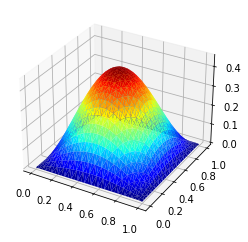

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

#Please choose the eige_index from 0 to 8.
eig_index=0

nodes = mesh.coordinates()
x = nodes[:,0]
y = nodes[:,1]

u = Function(V)
u.vector()[:] = eigenvectors[:, eig_index]*(-1)
if u((0.5,0.5))>0:
    z = u.compute_vertex_values(mesh)
else:
    z = -u.compute_vertex_values(mesh)
   
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.2)
plt.show()

## Step 6. Lower eigenvalue bounds
    
Calculate  the lower bounds for the leading 9 exact eigenvalues. 


In [25]:
Ch=0.1893*h;

import numpy as np

#The exact eigenvalues are only available for square domain.
exact_eigvalues = np.array([2,5,5,8,10,10,13,13,18])*pi**2;

# Extract the leading eigenpair from the smallest eigenvalue.
if domain=="square":
    for k in range(0,9):
        eig_value = eigenvalues_CR[k]
        exact_eig = exact_eigvalues[k]
        lower_bound = eig_value/(1+Ch*Ch*eig_value)
        print("The lower bound of %d theigenvalue: %10.5f  < %10.5f  (Difference: %10.5f) < %10.5f "%(k+1, lower_bound, exact_eig, exact_eig - lower_bound, eig_value ))
else:
    for k in range(0,9):
        eig_value = eigenvalues_CR[k]
        lower_bound = eig_value/(1+Ch*Ch*eig_value)
        print("The lower bound of %d theigenvalue: %10.5f"%(k+1, lower_bound))
    

The lower bound of 1 theigenvalue:   19.72030  <   19.73921  (Difference:    0.01890) <   19.73392 
The lower bound of 2 theigenvalue:   49.19447  <   49.34802  (Difference:    0.15356) <   49.27930 
The lower bound of 3 theigenvalue:   49.19447  <   49.34802  (Difference:    0.15356) <   49.27930 
The lower bound of 4 theigenvalue:   78.65515  <   78.95684  (Difference:    0.30169) <   78.87224 
The lower bound of 5 theigenvalue:   97.97299  <   98.69604  (Difference:    0.72305) <   98.31005 
The lower bound of 6 theigenvalue:   97.97299  <   98.69604  (Difference:    0.72305) <   98.31005 
The lower bound of 7 theigenvalue:  127.41162  <  128.30486  (Difference:    0.89324) <  127.98226 
The lower bound of 8 theigenvalue:  127.41162  <  128.30486  (Difference:    0.89324) <  127.98226 
The lower bound of 9 theigenvalue:  165.54388  <  177.65288  (Difference:   12.10900) <  166.50849 


## Step 7. Upper eigenvalue bounds
    
Calculate the upper bounds for the leading 9 exact eigenvalues by using the conforming Lagrange FEM. 


In [26]:
V = FunctionSpace(mesh, "CG", 1)
# define Dirichlet boundary conditions
def bdry(x, on_boundary):  return on_boundary

bc = DirichletBC(V, Constant(0.0), bdry)

# Define basis and bilinear form
u = TrialFunction(V)
v = TestFunction(V)
a = dot(grad(u), grad(v))*dx
b = dot(u, v)*dx

L = v*dx # To feed an argument to assemble_system
A, _ = assemble_system(a, L, bc) #The assemble_system commands make sure the symmetry of A
B = assemble(b)
bc.zero(B)

# downcast to PETSc matrices
MatA = as_backend_type(A)
MatB = as_backend_type(B)

eigenvalues_upper, eigenvectors = scipy_get_leading_eigenvalues(MatA, MatB, 9)

for k in range(0,9):
    eig_value_upper_bound = eigenvalues_upper[k]
    eig_value = eigenvalues_CR[k]
    lower_bound = eig_value/(1+Ch*Ch*eig_value)
    print("The lower and upper bound of eigenvalue: %10.5f <= lambda_%d <= %10.5f"%(lower_bound, k+1, eig_value_upper_bound))


The lower and upper bound of eigenvalue:   19.72030 <= lambda_1 <=   19.78679
The lower and upper bound of eigenvalue:   49.19447 <= lambda_2 <=   49.55253
The lower and upper bound of eigenvalue:   49.19447 <= lambda_3 <=   49.66736
The lower and upper bound of eigenvalue:   78.65515 <= lambda_4 <=   79.71606
The lower and upper bound of eigenvalue:   97.97299 <= lambda_5 <=   99.63288
The lower and upper bound of eigenvalue:   97.97299 <= lambda_6 <=   99.63811
The lower and upper bound of eigenvalue:  127.41162 <= lambda_7 <=  129.72900
The lower and upper bound of eigenvalue:  127.41162 <= lambda_8 <=  130.70526
The lower and upper bound of eigenvalue:  165.54388 <= lambda_9 <=  170.31163
